In [0]:
import numpy as np
import pandas as pd
import plotly as px
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from datetime import datetime
import time

import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql.functions import isnan, when, count, col

from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, StandardScaler, OneHotEncoder, SQLTransformer
from pyspark.ml.classification import LogisticRegression 
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.sql import Window

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import mlflow
import mlflow.spark

### Goal 
Try out the **RandomForest** algorithm that we built earlier, on our latest data with the most relevant features + new features

In [0]:
train_data = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/team20SSDK/project_data/train/part-00*.parquet")
val_data = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/team20SSDK/project_data/validation/part-00*.parquet")

print(train_data.count())
display(train_data)

16828952

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP DIV_AIRPORT_LANDINGS ORIGIN_TZ DEST_TZ DEP_MIN DEP_HOUR ARR_MIN ARR_HOUR ORIGIN_TS ORIGIN_UTC DEST_TS DEST_UTC ORIGIN_STATION ORIGIN_STATION_NAME DEST_STATION DEST_STATION_NAME ORIGIN_UTC_ADJ_MIN ORIGIN_UTC_ADJ_MAX ORIGIN_MAX_DATE DEST_MAX_DATE ORIGIN_FLIGHT_COUNT DEST_FLIGHT_COUNT DELAYS_SO_FAR CRS_ELAPSED_TIME_AVG_DIFF WEST_TO_EAST MINUTES_AFTER_MIDNIGHT_ORIGIN MINUTES_AFTER_MIDNIGHT_DEST HOLIDAY_WEEK DEP_HOUR_BIN ARR_HOUR_BIN NETWORK_CONGESTION ORIGIN_PR DEST_PR AVG_WND_SPEED_ORIGIN AVG_CIG_HEIGHT_ORIGIN MIN_CIG_HEIGHT_ORIGIN AVG_VIS_DIS_ORIGIN MIN_VIS_DIS_ORIGIN AVG_TMP_DEG_ORIGIN AVG_DEW_DEG_ORIGIN AVG_SLP_ORIGIN AVG_WND_SPEED_DEST AVG_CIG_HEIGHT_DEST MIN_CIG_HEIGHT_DEST AVG_VIS_DIS_DEST MIN_VIS_DIS_DEST AVG_TMP_DEG_DEST AVG_DEW_DEG_DEST AVG_SLP_DEST 2015 1 1 2 5 2015-01-02 EV 20366 EV N853AS 5527 10731 1073103 30731 BQK Brunswick, GA GA 13 Georgia 34 10397 1039705 30397 ATL Atlanta, GA GA 13 Georgia 34 1200 1156 -4.0 0.0 0.0 -1 1200-1259 34.0 1230 1319 4.0 1311 1323 12.0 12.0 0.0 0 1300-1359 0.0 0.0 71.0 87.0 49.0 1.0 238.0 1 0 America/New_York America/New_York 0 12 11 13 2015-01-02T12:00:00.000+0000 2015-01-02T17:00:00.000+0000 2015-01-02T13:11:00.000+0000 2015-01-02T18:11:00.000+0000 72213653883 BRUNSWICK GOLDEN ISLES APT 72219013874 HARTSFIELD-JACKSON ATLANTA IN 2014-12-31T15:00:00.000+0000 2015-01-02T15:00:00.000+0000 2015-01-02T14:55:00.000+0000 2015-01-02T14:52:00.000+0000 6 1913 0.0 -2.569039451114918 0 1020 1091 1 2 2 139488.0 5.289432718426684E-4 0.05675633205934823 15.27027027027027 8418.470588235294 30.0 11715.807692307691 201.0 130.97163120567376 96.10576923076923 10266.322188110027 15.280373831775702 1777.673076923077 152.0 14224.557692307691 2012.0 73.52857142857142 41.76923076923077 10271.767857142857 2015 2 6 15 1 2015-06-15 EV 20366 EV N900EV 5270 10731 1073103 30731 BQK Brunswick, GA GA 13 Georgia 34 10397 1039705 30397 ATL Atlanta, GA GA 13 Georgia 34 615 615 0.0 0.0 0.0 0 0600-0659 6.0 621 701 4.0 722 705 -17.0 0.0 0.0 -2 0700-0759 0.0 0.0 67.0 50.0 40.0 1.0 238.0 1 0 America/New_York America/New_York 15 6 22 7 2015-06-15T06:15:00.000+0000 2015-06-15T10:15:00.000+0000 2015-06-15T07:22:00.000+0000 2015-06-15T11:22:00.000+0000 72213653883 BRUNSWICK GOLDEN ISLES APT 72219013874 HARTSFIELD-JACKSON ATLANTA IN 2015-06-13T08:15:00.000+0000 2015-06-15T08:15:00.000+0000 2015-06-15T08:15:00.000+0000 2015-06-15T07:52:00.000+0000 6 2221 0.0 -6.569039451114918 0 615 682 0 1 1 52984.0 5.289432718426684E-4 0.05675633205934823 5.409090909090909 21167.25316455696 0.0 15067.585365853658 0.0 224.35593220338984 208.6153846153846 10185.347826086956 6.203312392918333 20192.23711340206 945.0 15275.927835051547 2816.0 221.1691176470588 206.48 10184.192307692309 2015 3 7 8 3 2015-07-08 EV 20366 EV N933EV 5094 10731 1073103 30731 BQK Brunswick, GA GA 13 Georgia 34 10397 1039705 30397 ATL Atlanta, GA GA 13 Georgia 34 615 615 0.0 0.0 0.0 0 0600-0659 4.0 619 658 4.0 722 702 -20.0 0.0 0.0 -2 0700-0759 0.0 0.0 67.0 47.0 39.0 1.0 238.0 1 0 America/New_York America/New_York 15 6 22 7 2015-07-08T06:15:00.000+0000 2015-07-08T10:15:00.000+0000 2015-07-08T07:22:00.000+0000 2015-07-08T11:22:00.000+0000 72213653883 BRUNSWICK GOLDEN ISLES APT 72219013874 HARTSFIELD-JACKSON ATLANTA IN 2015-07-06T08:15:00.000+0000 2015-07-08T08:15:00.000+0000 

### Lets look at the top features ranked by feature importance of our latest Random Forest Model

In [0]:
varlist = pd.read_csv('/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/rd_model_2/feat_imp.csv')
print(varlist.shape)
varlist.head(30)

(918, 4)
Out[35]:

idx 
 name 
 score 
 order 
 
 
 
 
 0 
 4 
 DELAYS_SO_FAR 
 0.276054 
 1 
 
 
 1 
 6 
 AVG_WND_SPEED_ORIGIN 
 0.033328 
 2 
 
 
 2 
 14 
 AVG_WND_SPEED_DEST 
 0.030614 
 3 
 
 
 3 
 793 
 DEP_HOUR_catVec_6 
 0.029792 
 4 
 
 
 4 
 11 
 AVG_TMP_DEG_ORIGIN 
 0.026060 
 5 
 
 
 5 
 19 
 AVG_TMP_DEG_DEST 
 0.019503 
 6 
 
 
 6 
 12 
 AVG_DEW_DEG_ORIGIN 
 0.019029 
 7 
 
 
 7 
 7 
 AVG_CIG_HEIGHT_ORIGIN 
 0.018695 
 8 
 
 
 8 
 15 
 AVG_CIG_HEIGHT_DEST 
 0.016018 
 9 
 
 
 9 
 9 
 AVG_VIS_DIS_ORIGIN 
 0.015002 
 10 
 
 
 10 
 794 
 DEP_HOUR_catVec_7 
 0.014643 
 11 
 
 
 11 
 37 
 ARR_HOUR_catVec_8 
 0.014506 
 12 
 
 
 12 
 0 
 ORIGIN_FLIGHT_COUNT 
 0.014058 
 13 
 
 
 13 
 32 
 ARR_HOUR_catVec_9 
 0.013290 
 14 
 
 
 14 
 13 
 AVG_SLP_ORIGIN 
 0.012951 
 15 
 
 
 15 
 10 
 MIN_VIS_DIS_ORIGIN 
 0.012680 
 16 
 
 
 16 
 17 
 AVG_VIS_DIS_DEST 
 0.012049 
 17 
 
 
 17 
 2 
 PAGERANK 
 0.011834 
 18 
 
 
 18 
 20 
 AVG_DEW_DEG_DEST 
 0.011454 
 19 
 
 
 19 
 810 
 DEP_HOUR_catVec_5 
 0.011179 
 20 
 
 
 20 
 8 
 MIN_CIG_HEIGHT_ORIGIN 
 0.011091 
 21 
 
 
 21 
 1 
 DEST_FLIGHT_COUNT 
 0.010763 
 22 
 
 
 22 
 21 
 AVG_SLP_DEST 
 0.010753 
 23 
 
 
 23 
 3 
 CRS_ELAPSED_TIME 
 0.010295 
 24 
 
 
 24 
 39 
 ARR_HOUR_catVec_7 
 0.010184 
 25 
 
 
 25 
 870 
 OP_UNIQUE_CARRIER_catVec_WN 
 0.009870 
 26 
 
 
 26 
 22 
 DISTANCE 
 0.009846 
 27 
 
 
 27 
 807 
 DEP_HOUR_catVec_20 
 0.009473 
 28 
 
 
 28 
 18 
 MIN_VIS_DIS_DEST 
 0.009203 
 29 
 
 
 29 
 16 
 MIN_CIG_HEIGHT_DEST 
 0.008984 
 30

In [0]:
varlist["score"].describe()

Out[4]: count 918.000000
mean 0.001089
std 0.009567
min 0.000000
25% 0.000007
50% 0.000026
75% 0.000185
max 0.276054
Name: score, dtype: float64

Out[15]:

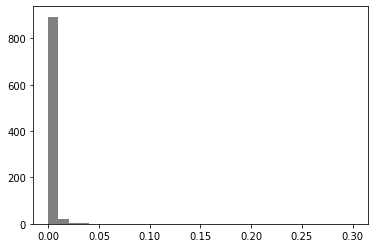

(array([893., 20., 2., 2., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0. , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ]),
 <a list of 30 Patch objects>)

In [0]:
plt.hist(varlist["score"], 30, range=[0.0, 0.3], facecolor='gray', align='mid')


In [0]:
top_20 = varlist[0:20]["name"]
list(top_20)

Out[17]: ['DELAYS_SO_FAR',
 'AVG_WND_SPEED_ORIGIN',
 'AVG_WND_SPEED_DEST',
 'DEP_HOUR_catVec_6',
 'AVG_TMP_DEG_ORIGIN',
 'AVG_TMP_DEG_DEST',
 'AVG_DEW_DEG_ORIGIN',
 'AVG_CIG_HEIGHT_ORIGIN',
 'AVG_CIG_HEIGHT_DEST',
 'AVG_VIS_DIS_ORIGIN',
 'DEP_HOUR_catVec_7',
 'ARR_HOUR_catVec_8',
 'ORIGIN_FLIGHT_COUNT',
 'ARR_HOUR_catVec_9',
 'AVG_SLP_ORIGIN',
 'MIN_VIS_DIS_ORIGIN',
 'AVG_VIS_DIS_DEST',
 'PAGERANK',
 'AVG_DEW_DEG_DEST',
 'DEP_HOUR_catVec_5']

#### Look at the new features from train data

In [0]:
print("Number of columns: ", len(train_data.columns))
np.array(train_data.columns)

Number of columns: 103
Out[3]: array(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID',
 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID',
 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
 'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID',
 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST',
 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS',
 'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME',
 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP',
 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED',
 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'DIV_AIRPORT_LANDINGS',
 'ORIGIN_TZ', 'DEST_TZ', 'DEP_MIN', 'DEP_HOUR', 'ARR_MIN',
 'ARR_HOUR', 'ORIGIN_TS', 'ORIGIN_UTC', 'DEST_TS', 'DEST_UTC',
 'ORIGIN_STATION', 'ORIGIN_STATION_NAME', 'DEST_STATION',
 'DEST_STATION_NAME', 'ORIGIN_UTC_ADJ_MIN', 'ORIGIN_UTC_ADJ_MAX',
 'ORIGIN_MAX_DATE', 'DEST_MAX_DATE', 'ORIGIN_FLIGHT_COUNT',
 'DEST_FLIGHT_COUNT', 'DELAYS_SO_FAR', 'CRS_ELAPSED_TIME_AVG_DIFF',
 'WEST_TO_EAST', 'MINUTES_AFTER_MIDNIGHT_ORIGIN',
 'MINUTES_AFTER_MIDNIGHT_DEST', 'HOLIDAY_WEEK', 'DEP_HOUR_BIN',
 'ARR_HOUR_BIN', 'NETWORK_CONGESTION', 'ORIGIN_PR', 'DEST_PR',
 'AVG_WND_SPEED_ORIGIN', 'AVG_CIG_HEIGHT_ORIGIN',
 'MIN_CIG_HEIGHT_ORIGIN', 'AVG_VIS_DIS_ORIGIN',
 'MIN_VIS_DIS_ORIGIN', 'AVG_TMP_DEG_ORIGIN', 'AVG_DEW_DEG_ORIGIN',
 'AVG_SLP_ORIGIN', 'AVG_WND_SPEED_DEST', 'AVG_CIG_HEIGHT_DEST',
 'MIN_CIG_HEIGHT_DEST', 'AVG_VIS_DIS_DEST', 'MIN_VIS_DIS_DEST',
 'AVG_TMP_DEG_DEST', 'AVG_DEW_DEG_DEST', 'AVG_SLP_DEST'],
 dtype='<U29')

In [0]:
#Manually override naming
top_20 = ['DELAYS_SO_FAR',
         'AVG_WND_SPEED_ORIGIN',
         'AVG_WND_SPEED_DEST',
         'AVG_TMP_DEG_ORIGIN',
         'AVG_TMP_DEG_DEST',
         'AVG_DEW_DEG_ORIGIN',
         'AVG_CIG_HEIGHT_ORIGIN',
         'AVG_CIG_HEIGHT_DEST',
         'AVG_VIS_DIS_ORIGIN',
         'ORIGIN_FLIGHT_COUNT',
         'AVG_SLP_ORIGIN',
         'MIN_VIS_DIS_ORIGIN',
         'AVG_VIS_DIS_DEST',
         'ORIGIN_PR',
         'DEST_PR',
         'AVG_DEW_DEG_DEST',
         'MIN_CIG_HEIGHT_ORIGIN',
         'DEST_FLIGHT_COUNT',
         'AVG_SLP_DEST',
         'CRS_ELAPSED_TIME']


new_features = ['CRS_ELAPSED_TIME_AVG_DIFF', 'WEST_TO_EAST', 'MINUTES_AFTER_MIDNIGHT_ORIGIN', 'MINUTES_AFTER_MIDNIGHT_DEST', 'HOLIDAY_WEEK', 'DEP_HOUR_BIN','ARR_HOUR_BIN','NETWORK_CONGESTION']

label_col = ['DEP_DEL15']

print(len(top_20))
print(len(new_features))
print(len(label_col))

keep_cols = set(top_20 + new_features + label_col)

print(len(keep_cols))

20
8
1
29

In [0]:
len(top_20 + new_features + label_col)

Out[19]: 29

In [0]:
#Keep on Train
train_final = train_data.select(*keep_cols)

#Keep on Val
val_final = val_data.select(*keep_cols)

print("Remaining Col Count: ", len(train_final.columns))
train_final.printSchema()
display(train_final)


Remaining Col Count: 29
root
-- MIN_CIG_HEIGHT_ORIGIN: double (nullable = true)
-- DEP_DEL15: double (nullable = true)
-- AVG_WND_SPEED_DEST: double (nullable = true)
-- DEST_PR: double (nullable = true)
-- AVG_VIS_DIS_ORIGIN: double (nullable = true)
-- AVG_TMP_DEG_ORIGIN: double (nullable = true)
-- HOLIDAY_WEEK: integer (nullable = true)
-- ARR_HOUR_BIN: integer (nullable = true)
-- AVG_DEW_DEG_DEST: double (nullable = true)
-- DEP_HOUR_BIN: integer (nullable = true)
-- AVG_TMP_DEG_DEST: double (nullable = true)
-- NETWORK_CONGESTION: double (nullable = true)
-- AVG_SLP_ORIGIN: double (nullable = true)
-- ORIGIN_FLIGHT_COUNT: long (nullable = true)
-- AVG_CIG_HEIGHT_ORIGIN: double (nullable = true)
-- CRS_ELAPSED_TIME_AVG_DIFF: double (nullable = true)
-- AVG_WND_SPEED_ORIGIN: double (nullable = true)
-- MINUTES_AFTER_MIDNIGHT_ORIGIN: integer (nullable = true)
-- DEST_FLIGHT_COUNT: long (nullable = true)
-- MINUTES_AFTER_MIDNIGHT_DEST: integer (nullable = true)
-- AVG_DEW_DEG_ORIGIN: double (nullable = true)
-- WEST_TO_EAST: integer (nullable = true)
-- MIN_VIS_DIS_ORIGIN: double (nullable = true)
-- AVG_VIS_DIS_DEST: double (nullable = true)
-- DELAYS_SO_FAR: double (nullable = true)
-- ORIGIN_PR: double (nullable = true)
-- AVG_SLP_DEST: double (nullable = true)
-- AVG_CIG_HEIGHT_DEST: double (nullable = true)
-- CRS_ELAPSED_TIME: double (nullable = true)

MIN_CIG_HEIGHT_ORIGIN DEP_DEL15 AVG_WND_SPEED_DEST DEST_PR AVG_VIS_DIS_ORIGIN AVG_TMP_DEG_ORIGIN HOLIDAY_WEEK ARR_HOUR_BIN AVG_DEW_DEG_DEST DEP_HOUR_BIN AVG_TMP_DEG_DEST NETWORK_CONGESTION AVG_SLP_ORIGIN ORIGIN_FLIGHT_COUNT AVG_CIG_HEIGHT_ORIGIN CRS_ELAPSED_TIME_AVG_DIFF AVG_WND_SPEED_ORIGIN MINUTES_AFTER_MIDNIGHT_ORIGIN DEST_FLIGHT_COUNT MINUTES_AFTER_MIDNIGHT_DEST AVG_DEW_DEG_ORIGIN WEST_TO_EAST MIN_VIS_DIS_ORIGIN AVG_VIS_DIS_DEST DELAYS_SO_FAR ORIGIN_PR AVG_SLP_DEST AVG_CIG_HEIGHT_DEST CRS_ELAPSED_TIME 30.0 0.0 15.280373831775702 0.05675633205934823 11715.807692307691 130.97163120567376 1 2 41.76923076923077 2 73.52857142857142 139488.0 10266.322188110027 6 8418.470588235294 -2.569039451114918 15.27027027027027 1020 1913 1091 96.10576923076923 0 201.0 14224.557692307691 0.0 5.289432718426684E-4 10271.767857142857 1777.673076923077 71.0 0.0 0.0 6.203312392918333 0.05675633205934823 15067.585365853658 224.35593220338984 0 1 206.48 1 221.1691176470588 52984.0 10185.347826086956 6 21167.25316455696 -6.569039451114918 5.409090909090909 615 2221 682 208.6153846153846 0 0.0 15275.927835051547 0.0 5.289432718426684E-4 10184.192307692309 20192.23711340206 67.0 22000.0 0.0 8.397702001482578 0.05675633205934823 14788.216216216217 222.41284403669724 0 1 206.57657657657657 1 218.81632653061226 48280.0 10200.666666666666 4 22000.0 -6.569039451114918 5.725 615 2225 682 211.53424657534248 0 3219.0 12531.712962962964 0.0 5.289432718426684E-4 10186.6875 14811.27619047619 67.0 30.0 0.0 22.379310344827587 0.05675633205934823 15744.012048192772 279.8677685950413 0 2 215.1946902654867 2 253.43624161073825 9936.0 10173.083333333334 5 20937.671641791047 -2.569039451114918 15.03370786516854 959 2055 1030 220.64705882352942 0 9656.0 13406.107142857143 0.0 5.289432718426684E-4 10181.09375 13662.036697247706 71.0 30.0 0.0 3.48 0.05675633205934823 14132.263157894737 227.51127819548873 0 1 204.63917525773195 1 218.26315789473685 22289.0 10121.896361936335 5 15301.268292682927 -6.569039451114918 12.386138613861386 615 2054 682 210.74725274725276 0 2414.0 12281.298969072164 0.0 5.289432718426684E-4 10135.28 20549.76595744681 67.0 61.0 0.0 18.807856598016784 0.05675633205934823 9179.944881889764 211.09036144578315 0 1 146.09448818897638 1 161.25443786982248 86108.0 10155.837670898482 6 2776.1961346266903 -4.569039451114918 16.954545454545453 675 2190 744 201.54032258064515 0 402.0 11244.266666666666 1.0 5.289432718426684E-4 10147.750840510842 4731.038167938931 69.0 91.0 0.0 38.92741935483871 0.05675633205934823 12376.113636363636 117.453125 0 3 32.84297520661157 3 87.40127388535032 75972.0 10181.35807453416 6 8166.662790697675 1.430960548885082 37.71578947368421 1285 2026 1360 60.81521739130435 0 2012.0 10571.92561983471 0.0 5.289432718426684E-4 10144.976561771562 4085.613346438475 75.0 1524.0 0.0 37.352380952380955 0.05675633205934823 16034.843373493975 158.5206611570248 0 2 59.43269230769231 2 114.58865248226951 2440.0 10209.478260869566 6 21337.51282051282 4.430960548885082 37.50561797752809 1034 2131 1112 69.18823529411765 0 14484.0 15571.914285714285 0.0 5.289432718426684E-4 10195.443548387097 14343.773195876289 78.0 91.0 0.0 5.852173913043479 0.05675633205934823 13773.520408163266 219.61029411764707 1 1 176.1090909090909 1 194.8918918918919 56433.0 10171.680000000002 6 20076.842105263157 -8.569039451114918 6.223300970873787 615 2265 680 206.0721649484536 0 1207.0 8355.473214285714 0.0 5.289432718426684E-4 10167.626008064517 12431.54128440367 65.0 61.0 0.0 3.5217391304347827 0.05675633205934823 12969.845360824742 165.2356757292131 0 1 108.75 1 119.1554054054054 30873.0 10217.657016818306 6 19584.61461038961 -8.569039451114918 10.663157894736843 615 2211 680 150.30759149107774 0 402.0 12867.267857142857 0.0 5.289432718426684E-4 10238.622895622895 15688.88392857143 65.0 6096.0 1.0 7.418181818181818 0.05675633205934823 15562.670454545454 200.38333333333333 0 2 118.1214953271028 2 139.6993006993007 5852.0 10242.192307692309 6 20859.68831168831 4.430960548

In [0]:
cat_cols = ['DEP_HOUR_BIN', 'ARR_HOUR_BIN', 'WEST_TO_EAST', 'HOLIDAY_WEEK']

num_cols = ['DELAYS_SO_FAR','AVG_WND_SPEED_ORIGIN','AVG_WND_SPEED_DEST','AVG_TMP_DEG_ORIGIN',
            'AVG_TMP_DEG_DEST', 'AVG_DEW_DEG_ORIGIN', 'AVG_CIG_HEIGHT_ORIGIN', 'AVG_CIG_HEIGHT_DEST',
            'AVG_VIS_DIS_ORIGIN', 'ORIGIN_FLIGHT_COUNT', 'AVG_SLP_ORIGIN', 'MIN_VIS_DIS_ORIGIN',
            'AVG_VIS_DIS_DEST','ORIGIN_PR','DEST_PR','AVG_DEW_DEG_DEST', 'MIN_CIG_HEIGHT_ORIGIN',
            'DEST_FLIGHT_COUNT', 'AVG_SLP_DEST','CRS_ELAPSED_TIME', 'CRS_ELAPSED_TIME_AVG_DIFF',
            'MINUTES_AFTER_MIDNIGHT_ORIGIN', 'MINUTES_AFTER_MIDNIGHT_DEST', 'NETWORK_CONGESTION']

len(set(cat_cols + num_cols))

Out[6]: 28

In [0]:
cols_by_cat = 0
for col in cat_cols:
    col_count = train_final.select(col).distinct().count()
    cols_by_cat += col_count
    print(col, ": ", col_count)

print()
tot_col_count = len(num_cols)+cols_by_cat
print("Number of columns after OHE: ", tot_col_count)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-4061768275123380> in <module> 
 1 cols_by_cat = 0 
 ----> 2 for col in cat_cols : 
 3 col_count = train_final . select ( col ) . distinct ( ) . count ( ) 
 4 cols_by_cat += col_count
 5 print ( col , ": " , col_count ) 

 NameError : name 'cat_cols' is not defined

This means we are reducing model parsimony from **918** to **43** columns

In [0]:
#Apply Balance Ratio, build this only from Train
balancing_ratio = train_final.filter("DEP_DEL15 == 0").count() / train_final.count()

print("Balancing Ratio =", balancing_ratio)

train_final = train_final.withColumn("CLASS_WEIGHTS", when(train_final.DEP_DEL15 == 1, balancing_ratio) \
                               .otherwise(1 - balancing_ratio))


val_final = val_final.withColumn("CLASS_WEIGHTS", when(val_final.DEP_DEL15 == 1, balancing_ratio) \
                               .otherwise(1 - balancing_ratio))

Balancing Ratio = 0.8213681992794323

#### To Extract Feature Importance

In [0]:
#Returns a Pandas DF with top features and scores
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

### M4 - Random Forest

Trimmed down to take the top 21 features from feature importance, also including latest added feature engineered features

In [0]:
m3_cat = cat_cols
m3_cols = list(set(m3_cat + num_cols + label_col)) + ["CLASS_WEIGHTS"]
m3_train = train_final.select(*m3_cols).withColumnRenamed('DEP_DEL15', 'label')
m3_val = val_final.select(*m3_cols).withColumnRenamed('DEP_DEL15', 'label')

print((m3_train.count(), len(m3_train.columns)))
print((m3_val.count(), len(m3_val.columns)))
display(m3_train)

(16828952, 30)
(7071462, 30)

MIN_CIG_HEIGHT_ORIGIN label AVG_WND_SPEED_DEST DEST_PR AVG_VIS_DIS_ORIGIN AVG_TMP_DEG_ORIGIN HOLIDAY_WEEK ARR_HOUR_BIN AVG_DEW_DEG_DEST DEP_HOUR_BIN AVG_TMP_DEG_DEST NETWORK_CONGESTION AVG_SLP_ORIGIN ORIGIN_FLIGHT_COUNT AVG_CIG_HEIGHT_ORIGIN CRS_ELAPSED_TIME_AVG_DIFF AVG_WND_SPEED_ORIGIN MINUTES_AFTER_MIDNIGHT_ORIGIN DEST_FLIGHT_COUNT MINUTES_AFTER_MIDNIGHT_DEST WEST_TO_EAST AVG_DEW_DEG_ORIGIN MIN_VIS_DIS_ORIGIN AVG_VIS_DIS_DEST DELAYS_SO_FAR ORIGIN_PR AVG_SLP_DEST AVG_CIG_HEIGHT_DEST CRS_ELAPSED_TIME CLASS_WEIGHTS 30.0 0.0 15.280373831775702 0.05675633205934823 11715.807692307691 130.97163120567376 1 2 41.76923076923077 2 73.52857142857142 139488.0 10266.322188110027 6 8418.470588235294 -2.569039451114918 15.27027027027027 1020 1913 1091 0 96.10576923076923 201.0 14224.557692307691 0.0 5.289432718426684E-4 10271.767857142857 1777.673076923077 71.0 0.17863180072056772 0.0 0.0 6.203312392918333 0.05675633205934823 15067.585365853658 224.35593220338984 0 1 206.48 1 221.1691176470588 52984.0 10185.347826086956 6 21167.25316455696 -6.569039451114918 5.409090909090909 615 2221 682 0 208.6153846153846 0.0 15275.927835051547 0.0 5.289432718426684E-4 10184.192307692309 20192.23711340206 67.0 0.17863180072056772 22000.0 0.0 8.397702001482578 0.05675633205934823 14788.216216216217 222.41284403669724 0 1 206.57657657657657 1 218.81632653061226 48280.0 10200.666666666666 4 22000.0 -6.569039451114918 5.725 615 2225 682 0 211.53424657534248 3219.0 12531.712962962964 0.0 5.289432718426684E-4 10186.6875 14811.27619047619 67.0 0.17863180072056772 30.0 0.0 22.379310344827587 0.05675633205934823 15744.012048192772 279.8677685950413 0 2 215.1946902654867 2 253.43624161073825 9936.0 10173.083333333334 5 20937.671641791047 -2.569039451114918 15.03370786516854 959 2055 1030 0 220.64705882352942 9656.0 13406.107142857143 0.0 5.289432718426684E-4 10181.09375 13662.036697247706 71.0 0.17863180072056772 30.0 0.0 3.48 0.05675633205934823 14132.263157894737 227.51127819548873 0 1 204.63917525773195 1 218.26315789473685 22289.0 10121.896361936335 5 15301.268292682927 -6.569039451114918 12.386138613861386 615 2054 682 0 210.74725274725276 2414.0 12281.298969072164 0.0 5.289432718426684E-4 10135.28 20549.76595744681 67.0 0.17863180072056772 61.0 0.0 18.807856598016784 0.05675633205934823 9179.944881889764 211.09036144578315 0 1 146.09448818897638 1 161.25443786982248 86108.0 10155.837670898482 6 2776.1961346266903 -4.569039451114918 16.954545454545453 675 2190 744 0 201.54032258064515 402.0 11244.266666666666 1.0 5.289432718426684E-4 10147.750840510842 4731.038167938931 69.0 0.17863180072056772 91.0 0.0 38.92741935483871 0.05675633205934823 12376.113636363636 117.453125 0 3 32.84297520661157 3 87.40127388535032 75972.0 10181.35807453416 6 8166.662790697675 1.430960548885082 37.71578947368421 1285 2026 1360 0 60.81521739130435 2012.0 10571.92561983471 0.0 5.289432718426684E-4 10144.976561771562 4085.613346438475 75.0 0.17863180072056772 1524.0 0.0 37.352380952380955 0.05675633205934823 16034.843373493975 158.5206611570248 0 2 59.43269230769231 2 114.58865248226951 2440.0 10209.478260869566 6 21337.51282051282 4.430960548885082 37.50561797752809 1034 2131 1112 0 69.18823529411765 14484.0 15571.914285714285 0.0 5.289432718426684E-4 10195.443548387097 14343.773195876289 78.0 0.17863180072056772 91.0 0.0 5.852173913043479 0.05675633205934823 13773.520408163266 219.61029411764707 1 1 176.1090909090909 1 194.8918918918919 56433.0 10171.680000000002 6 20076.842105263157 -8.569039451114918 6.223300970873787 615 2265 680 0 206.0721649484536 1207.0 8355.473214285714 0.0 5.289432718426684E-4 10167.626008064517 12431.54128440367 65.0 0.17863180072056772 61.0 0.0 3.5217391304347827 0.05675633205934823 12969.845360824742 165.2356757292131 0 1 108.75 1 119.1554054054054 30873.0 10217.657016818306 6 19584.61461038961 -8.569039451114918 10.663157894736843 615 2211 680 0 150.30759149107774 402.0 12867.267857142857 0.0 5.289432718426684E-4 10238.622895622895 15688.88392857143 6

In [0]:
col_vec_out = [x+'_catVec' for x in m3_cat]

#StringIndex into labelled indices
indexers = [StringIndexer(inputCol=x, outputCol= x+'_tmp') for x in m3_cat]

#OneHotEncoder, indices into sparse one hot encoded columns
encoders = [OneHotEncoder(dropLast=False, inputCol=x+'_tmp', outputCol=y) for x,y in zip(m3_cat, col_vec_out)]

#Create pair of zips
stages = [[i,j] for i,j in zip(indexers, encoders)]

#Flatten into stages
stages = [stage for sublist in stages for stage in sublist]

In [0]:
m3_cols = num_cols + col_vec_out
vector_assembler = VectorAssembler(inputCols=m3_cols, outputCol="features", handleInvalid='skip')
stages += [vector_assembler]

In [0]:
#Helper function to check and create a path if it doesn't exist already
def path_exists(path):
    print("Path: ", path)
    try:
        dbutils.fs.ls(path)
        return True
    except Exception as e:
        dbutils.fs.mkdirs(path)        
        return False

In [0]:
%%time

model_version = "rf_model_4"
nTree = 30
mDep = 15
subSamp = 1.0

# Explicitly create a new run.
# This allows this cell to be run multiple times.
# If you omit mlflow.start_run(), then this cell could run once, but a second run would hit conflicts when attempting to overwrite the first run.
with mlflow.start_run():

    start = time.time()
    pipeline = Pipeline().setStages(stages)
  
    #MISLEADING - No model fitting is happening here. Just creating the 1 hot encoded columns
    train_pip = pipeline.fit(m3_train).transform(m3_train)
    val_pip = pipeline.fit(m3_val).transform(m3_val)
    done = time.time()
    mlflow.log_metric('pip_fit_time' ,done - start)

    rf = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="CLASS_WEIGHTS",
                            numTrees=nTree, maxDepth=mDep, cacheNodeIds = True, subsamplingRate = subSamp)  
    mlflow.log_param('numTrees', nTree)
    mlflow.log_param('maxDepth', mDep)
    mlflow.log_param('cacheNodeIds', True)
    mlflow.log_param('subsamplingRate', subSamp)  

    start = time.time()
    rf_model = rf.fit(train_pip)
    done = time.time()
    mlflow.log_metric('model_fit_time' ,done - start)

    start = time.time()
    m3_train_results = rf_model.transform(train_pip)
    done = time.time()
    mlflow.log_metric('train_pred_time' ,done - start)  

    start = time.time()
    m3_val_results = rf_model.transform(val_pip)
    done = time.time()
    mlflow.log_metric('val_pred_time' ,done - start)

    #Set up BinClassEval
    evaluator = BinaryClassificationEvaluator()
    evaluator.setRawPredictionCol("raw")

    trainScoreAndLabels = m3_train_results.select(['probability','label', f.col("prediction").alias("raw")])
    valScoreAndLabels = m3_val_results.select(['probability','label', f.col("prediction").alias("raw")])

    print("Train Set")
    start=time.time()
    train_pr = evaluator.evaluate(trainScoreAndLabels, {evaluator.metricName: "areaUnderPR"})
    train_roc = evaluator.evaluate(trainScoreAndLabels, {evaluator.metricName: "areaUnderROC"})
    done = time.time()
    mlflow.log_metric('train_metric_time' ,done - start)  

    print("train areaUnderPR: ", train_pr)
    print("train areaUnderROC: ", train_roc)
    mlflow.log_metric('train_pr' ,train_pr)
    mlflow.log_metric('train_roc' ,train_roc)
    print()

    print("Validation Set")
    start =time.time()
    val_pr = evaluator.evaluate(valScoreAndLabels, {evaluator.metricName: "areaUnderPR"})
    val_roc = evaluator.evaluate(valScoreAndLabels, {evaluator.metricName: "areaUnderROC"})
    done = time.time()
    mlflow.log_metric('val_metric_time' ,done - start)    

    print("val areaUnderPR: ", val_pr)
    print("val areaUnderROC: ", val_roc)
    mlflow.log_metric('val_pr' , val_pr)
    mlflow.log_metric('val_roc' ,val_roc)  

    # Log this model.
    mlflow.spark.log_model(spark_model=rf_model, artifact_path=model_version)

    start =time.time()
    #Save the model out in case we need to reference again in the future
    rf_model.write().overwrite().save(f"dbfs:/mnt/mids-w261/team20SSDK/models/{model_version}")
    done = time.time()
    mlflow.log_metric('model_save_time' ,done - start)     

    start =time.time()
    #m3_train_results input is just used for Schema purposes
    varlist = ExtractFeatureImp(rf_model.featureImportances, m3_val_results, "features")
    varlist["order"] = np.arange(1, len(varlist["idx"])+1)
    done = time.time()
    mlflow.log_metric('extract_feat_imp_time' ,done - start)   

    start =time.time()
    #Log these artifacts for graphs and charts later on
    trainScoreAndLabels_pd = trainScoreAndLabels.toPandas()
    valScoreAndLabels_pd = valScoreAndLabels.toPandas()
    
    #Create Path if it doesn't exist
    path_exists(f'dbfs:/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}')
    
    #Extract it all to evaluate later on.
    varlist.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv', index=False)
    valScoreAndLabels_pd.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv', index=False)
    trainScoreAndLabels_pd.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv',index=False)
    done = time.time()
    mlflow.log_metric('ouput_to_pd_time' , done - start)
    
    # Log the saved table as an artifact
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv')
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv')
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv')    
  

Train Set
train areaUnderPR: 0.3289460023573455
train areaUnderROC: 0.703191032177894

Validation Set
val areaUnderPR: 0.32970867006151944
val areaUnderROC: 0.6831465912650859
/databricks/spark/python/pyspark/sql/pandas/conversion.py:93: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Path: dbfs:/mnt/mids-w261/team20SSDK/models/model_meta/rf_model_4
CPU times: user 8min 35s, sys: 34.3 s, total: 9min 9s
Wall time: 22min 43s

### M5 - Random Forest

In [0]:
%%time

model_version = "rf_model_5"
nTree = 40
mDep = 15
subSamp = 1.0

# Explicitly create a new run.
# This allows this cell to be run multiple times.
# If you omit mlflow.start_run(), then this cell could run once, but a second run would hit conflicts when attempting to overwrite the first run.
with mlflow.start_run():

    start = time.time()
    pipeline = Pipeline().setStages(stages)
  
    #MISLEADING - No model fitting is happening here. Just creating the 1 hot encoded columns
    train_pip = pipeline.fit(m3_train).transform(m3_train)
    val_pip = pipeline.fit(m3_val).transform(m3_val)
    done = time.time()
    mlflow.log_metric('pip_fit_time' ,done - start)

    rf = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="CLASS_WEIGHTS",
                            numTrees=nTree, maxDepth=mDep, cacheNodeIds = True, subsamplingRate = subSamp)  
    mlflow.log_param('numTrees', nTree)
    mlflow.log_param('maxDepth', mDep)
    mlflow.log_param('cacheNodeIds', True)
    mlflow.log_param('subsamplingRate', subSamp)  

    start = time.time()
    rf_model = rf.fit(train_pip)
    done = time.time()
    mlflow.log_metric('model_fit_time' ,done - start)

    start = time.time()
    m3_train_results = rf_model.transform(train_pip)
    done = time.time()
    mlflow.log_metric('train_pred_time' ,done - start)  

    start = time.time()
    m3_val_results = rf_model.transform(val_pip)
    done = time.time()
    mlflow.log_metric('val_pred_time' ,done - start)

    #Set up BinClassEval
    evaluator = BinaryClassificationEvaluator()
    evaluator.setRawPredictionCol("raw")

    trainScoreAndLabels = m3_train_results.select(['probability','label', f.col("prediction").alias("raw")])
    valScoreAndLabels = m3_val_results.select(['probability','label', f.col("prediction").alias("raw")])

    print("Train Set")
    start=time.time()
    train_pr = evaluator.evaluate(trainScoreAndLabels, {evaluator.metricName: "areaUnderPR"})
    train_roc = evaluator.evaluate(trainScoreAndLabels, {evaluator.metricName: "areaUnderROC"})
    done = time.time()
    mlflow.log_metric('train_metric_time' ,done - start)  

    print("train areaUnderPR: ", train_pr)
    print("train areaUnderROC: ", train_roc)
    mlflow.log_metric('train_pr' ,train_pr)
    mlflow.log_metric('train_roc' ,train_roc)
    print()

    print("Validation Set")
    start =time.time()
    val_pr = evaluator.evaluate(valScoreAndLabels, {evaluator.metricName: "areaUnderPR"})
    val_roc = evaluator.evaluate(valScoreAndLabels, {evaluator.metricName: "areaUnderROC"})
    done = time.time()
    mlflow.log_metric('val_metric_time' ,done - start)    

    print("val areaUnderPR: ", val_pr)
    print("val areaUnderROC: ", val_roc)
    mlflow.log_metric('val_pr' , val_pr)
    mlflow.log_metric('val_roc' ,val_roc)  

    # Log this model.
    mlflow.spark.log_model(spark_model=rf_model, artifact_path=model_version)

    start =time.time()
    #Save the model out in case we need to reference again in the future
    rf_model.write().overwrite().save(f"dbfs:/mnt/mids-w261/team20SSDK/models/{model_version}")
    done = time.time()
    mlflow.log_metric('model_save_time' ,done - start)     

    start =time.time()
    #m3_train_results input is just used for Schema purposes
    varlist = ExtractFeatureImp(rf_model.featureImportances, m3_val_results, "features")
    varlist["order"] = np.arange(1, len(varlist["idx"])+1)
    done = time.time()
    mlflow.log_metric('extract_feat_imp_time' ,done - start)   

    start =time.time()
    #Log these artifacts for graphs and charts later on
    trainScoreAndLabels_pd = trainScoreAndLabels.toPandas()
    valScoreAndLabels_pd = valScoreAndLabels.toPandas()
    
    #Create Path if it doesn't exist
    path_exists(f'dbfs:/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}')
    
    #Extract it all to evaluate later on.
    varlist.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv', index=False)
    valScoreAndLabels_pd.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv', index=False)
    trainScoreAndLabels_pd.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv',index=False)
    done = time.time()
    mlflow.log_metric('ouput_to_pd_time' , done - start)
    
    # Log the saved table as an artifact
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv')
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv')
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv')    
  

Train Set
train areaUnderPR: 0.32846406533290673
train areaUnderROC: 0.7033056039223531

Validation Set
val areaUnderPR: 0.3287425753216472
val areaUnderROC: 0.6836346349826139
Path: dbfs:/mnt/mids-w261/team20SSDK/models/model_meta/rf_model_5
CPU times: user 9min 28s, sys: 1min 13s, total: 10min 42s
Wall time: 29min 8s

### M6 - Random Forest

In [0]:
%%time

model_version = "rf_model_6"
nTree = 40
mDep = 20
subSamp = 1.0

# Explicitly create a new run.
# This allows this cell to be run multiple times.
# If you omit mlflow.start_run(), then this cell could run once, but a second run would hit conflicts when attempting to overwrite the first run.
with mlflow.start_run():

    start = time.time()
    pipeline = Pipeline().setStages(stages)
  
    #MISLEADING - No model fitting is happening here. Just creating the 1 hot encoded columns
    train_pip = pipeline.fit(m3_train).transform(m3_train)
    val_pip = pipeline.fit(m3_val).transform(m3_val)
    done = time.time()
    mlflow.log_metric('pip_fit_time' ,done - start)

    rf = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="CLASS_WEIGHTS",
                            numTrees=nTree, maxDepth=mDep, cacheNodeIds = True, subsamplingRate = subSamp)  
    mlflow.log_param('numTrees', nTree)
    mlflow.log_param('maxDepth', mDep)
    mlflow.log_param('cacheNodeIds', True)
    mlflow.log_param('subsamplingRate', subSamp)  

    start = time.time()
    rf_model = rf.fit(train_pip)
    done = time.time()
    mlflow.log_metric('model_fit_time' ,done - start)

    start = time.time()
    m3_train_results = rf_model.transform(train_pip)
    done = time.time()
    mlflow.log_metric('train_pred_time' ,done - start)  

    start = time.time()
    m3_val_results = rf_model.transform(val_pip)
    done = time.time()
    mlflow.log_metric('val_pred_time' ,done - start)

    #Set up BinClassEval
    evaluator = BinaryClassificationEvaluator()
    evaluator.setRawPredictionCol("raw")

    trainScoreAndLabels = m3_train_results.select(['probability','label', f.col("prediction").alias("raw")])
    valScoreAndLabels = m3_val_results.select(['probability','label', f.col("prediction").alias("raw")])

    print("Train Set")
    start=time.time()
    train_pr = evaluator.evaluate(trainScoreAndLabels, {evaluator.metricName: "areaUnderPR"})
    train_roc = evaluator.evaluate(trainScoreAndLabels, {evaluator.metricName: "areaUnderROC"})
    done = time.time()
    mlflow.log_metric('train_metric_time' ,done - start)  

    print("train areaUnderPR: ", train_pr)
    print("train areaUnderROC: ", train_roc)
    mlflow.log_metric('train_pr' ,train_pr)
    mlflow.log_metric('train_roc' ,train_roc)
    print()

    print("Validation Set")
    start =time.time()
    val_pr = evaluator.evaluate(valScoreAndLabels, {evaluator.metricName: "areaUnderPR"})
    val_roc = evaluator.evaluate(valScoreAndLabels, {evaluator.metricName: "areaUnderROC"})
    done = time.time()
    mlflow.log_metric('val_metric_time' ,done - start)    

    print("val areaUnderPR: ", val_pr)
    print("val areaUnderROC: ", val_roc)
    mlflow.log_metric('val_pr' , val_pr)
    mlflow.log_metric('val_roc' ,val_roc)  

    # Log this model.
    mlflow.spark.log_model(spark_model=rf_model, artifact_path=model_version)

    start =time.time()
    #Save the model out in case we need to reference again in the future
    rf_model.write().overwrite().save(f"dbfs:/mnt/mids-w261/team20SSDK/models/{model_version}")
    done = time.time()
    mlflow.log_metric('model_save_time' ,done - start)     

    start =time.time()
    #m3_train_results input is just used for Schema purposes
    varlist = ExtractFeatureImp(rf_model.featureImportances, m3_val_results, "features")
    varlist["order"] = np.arange(1, len(varlist["idx"])+1)
    done = time.time()
    mlflow.log_metric('extract_feat_imp_time' ,done - start)   

    start =time.time()
    #Log these artifacts for graphs and charts later on
    trainScoreAndLabels_pd = trainScoreAndLabels.toPandas()
    valScoreAndLabels_pd = valScoreAndLabels.toPandas()
    
    #Create Path if it doesn't exist
    path_exists(f'dbfs:/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}')
    
    #Extract it all to evaluate later on.
    varlist.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv', index=False)
    valScoreAndLabels_pd.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv', index=False)
    trainScoreAndLabels_pd.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv',index=False)
    done = time.time()
    mlflow.log_metric('ouput_to_pd_time' , done - start)
    
    # Log the saved table as an artifact
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv')
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv')
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv')    
  

java.lang.RuntimeException: abort: DriverClient destroyed
	at com.databricks.backend.daemon.driver.DriverClient.$anonfun$poll$3(DriverClient.scala:381)
	at scala.concurrent.Future.$anonfun$flatMap$1(Future.scala:307)
	at scala.concurrent.impl.Promise.$anonfun$transformWith$1(Promise.scala:41)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at com.databricks.threading.NamedExecutor$$anon$2.$anonfun$run$1(NamedExecutor.scala:345)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:240)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:235)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:232)
	at com.databricks.threading.NamedExecutor.withAttributionContext(NamedExecutor.scala:275)
	at com.databricks.threading.NamedExecutor$$anon$2.run(NamedExecutor.scala:345)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

### M7 - Random Forest

In [0]:
%%time

model_version = "rf_model_7"
nTree = 50
mDep = 20
subSamp = 1.0

# Explicitly create a new run.
# This allows this cell to be run multiple times.
# If you omit mlflow.start_run(), then this cell could run once, but a second run would hit conflicts when attempting to overwrite the first run.
with mlflow.start_run():

    start = time.time()
    pipeline = Pipeline().setStages(stages)
  
    #MISLEADING - No model fitting is happening here. Just creating the 1 hot encoded columns
    train_pip = pipeline.fit(m3_train).transform(m3_train)
    val_pip = pipeline.fit(m3_val).transform(m3_val)
    done = time.time()
    mlflow.log_metric('pip_fit_time' ,done - start)

    rf = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="CLASS_WEIGHTS",
                            numTrees=nTree, maxDepth=mDep, cacheNodeIds = True, subsamplingRate = subSamp)  
    mlflow.log_param('numTrees', nTree)
    mlflow.log_param('maxDepth', mDep)
    mlflow.log_param('cacheNodeIds', True)
    mlflow.log_param('subsamplingRate', subSamp)  

    start = time.time()
    rf_model = rf.fit(train_pip)
    done = time.time()
    mlflow.log_metric('model_fit_time' ,done - start)

    start = time.time()
    m3_train_results = rf_model.transform(train_pip)
    done = time.time()
    mlflow.log_metric('train_pred_time' ,done - start)  

    start = time.time()
    m3_val_results = rf_model.transform(val_pip)
    done = time.time()
    mlflow.log_metric('val_pred_time' ,done - start)

    #Set up BinClassEval
    evaluator = BinaryClassificationEvaluator()
    evaluator.setRawPredictionCol("raw")

    trainScoreAndLabels = m3_train_results.select(['probability','label', f.col("prediction").alias("raw")])
    valScoreAndLabels = m3_val_results.select(['probability','label', f.col("prediction").alias("raw")])

    print("Train Set")
    start=time.time()
    train_pr = evaluator.evaluate(trainScoreAndLabels, {evaluator.metricName: "areaUnderPR"})
    train_roc = evaluator.evaluate(trainScoreAndLabels, {evaluator.metricName: "areaUnderROC"})
    done = time.time()
    mlflow.log_metric('train_metric_time' ,done - start)  

    print("train areaUnderPR: ", train_pr)
    print("train areaUnderROC: ", train_roc)
    mlflow.log_metric('train_pr' ,train_pr)
    mlflow.log_metric('train_roc' ,train_roc)
    print()

    print("Validation Set")
    start =time.time()
    val_pr = evaluator.evaluate(valScoreAndLabels, {evaluator.metricName: "areaUnderPR"})
    val_roc = evaluator.evaluate(valScoreAndLabels, {evaluator.metricName: "areaUnderROC"})
    done = time.time()
    mlflow.log_metric('val_metric_time' ,done - start)    

    print("val areaUnderPR: ", val_pr)
    print("val areaUnderROC: ", val_roc)
    mlflow.log_metric('val_pr' , val_pr)
    mlflow.log_metric('val_roc' ,val_roc)  

    # Log this model.
    mlflow.spark.log_model(spark_model=rf_model, artifact_path=model_version)

    start =time.time()
    #Save the model out in case we need to reference again in the future
    rf_model.write().overwrite().save(f"dbfs:/mnt/mids-w261/team20SSDK/models/{model_version}")
    done = time.time()
    mlflow.log_metric('model_save_time' ,done - start)     

    start =time.time()
    #m3_train_results input is just used for Schema purposes
    varlist = ExtractFeatureImp(rf_model.featureImportances, m3_val_results, "features")
    varlist["order"] = np.arange(1, len(varlist["idx"])+1)
    done = time.time()
    mlflow.log_metric('extract_feat_imp_time' ,done - start)   

    start =time.time()
    #Log these artifacts for graphs and charts later on
    trainScoreAndLabels_pd = trainScoreAndLabels.toPandas()
    valScoreAndLabels_pd = valScoreAndLabels.toPandas()
    
    #Create Path if it doesn't exist
    path_exists(f'dbfs:/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}')
    
    #Extract it all to evaluate later on.
    varlist.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv', index=False)
    valScoreAndLabels_pd.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv', index=False)
    trainScoreAndLabels_pd.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv',index=False)
    done = time.time()
    mlflow.log_metric('ouput_to_pd_time' , done - start)
    
    # Log the saved table as an artifact
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv')
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv')
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv')    
  

### M8 - Random Forest

In [0]:
%%time

model_version = "rf_model_8"
nTree = 50
mDep = 25
subSamp = 1.0

# Explicitly create a new run.
# This allows this cell to be run multiple times.
# If you omit mlflow.start_run(), then this cell could run once, but a second run would hit conflicts when attempting to overwrite the first run.
with mlflow.start_run():

    start = time.time()
    pipeline = Pipeline().setStages(stages)
  
    #MISLEADING - No model fitting is happening here. Just creating the 1 hot encoded columns
    train_pip = pipeline.fit(m3_train).transform(m3_train)
    val_pip = pipeline.fit(m3_val).transform(m3_val)
    done = time.time()
    mlflow.log_metric('pip_fit_time' ,done - start)

    rf = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="CLASS_WEIGHTS",
                            numTrees=nTree, maxDepth=mDep, cacheNodeIds = True, subsamplingRate = subSamp)  
    mlflow.log_param('numTrees', nTree)
    mlflow.log_param('maxDepth', mDep)
    mlflow.log_param('cacheNodeIds', True)
    mlflow.log_param('subsamplingRate', subSamp)  

    start = time.time()
    rf_model = rf.fit(train_pip)
    done = time.time()
    mlflow.log_metric('model_fit_time' ,done - start)

    start = time.time()
    m3_train_results = rf_model.transform(train_pip)
    done = time.time()
    mlflow.log_metric('train_pred_time' ,done - start)  

    start = time.time()
    m3_val_results = rf_model.transform(val_pip)
    done = time.time()
    mlflow.log_metric('val_pred_time' ,done - start)

    #Set up BinClassEval
    evaluator = BinaryClassificationEvaluator()
    evaluator.setRawPredictionCol("raw")

    trainScoreAndLabels = m3_train_results.select(['probability','label', f.col("prediction").alias("raw")])
    valScoreAndLabels = m3_val_results.select(['probability','label', f.col("prediction").alias("raw")])

    print("Train Set")
    start=time.time()
    train_pr = evaluator.evaluate(trainScoreAndLabels, {evaluator.metricName: "areaUnderPR"})
    train_roc = evaluator.evaluate(trainScoreAndLabels, {evaluator.metricName: "areaUnderROC"})
    done = time.time()
    mlflow.log_metric('train_metric_time' ,done - start)  

    print("train areaUnderPR: ", train_pr)
    print("train areaUnderROC: ", train_roc)
    mlflow.log_metric('train_pr' ,train_pr)
    mlflow.log_metric('train_roc' ,train_roc)
    print()

    print("Validation Set")
    start =time.time()
    val_pr = evaluator.evaluate(valScoreAndLabels, {evaluator.metricName: "areaUnderPR"})
    val_roc = evaluator.evaluate(valScoreAndLabels, {evaluator.metricName: "areaUnderROC"})
    done = time.time()
    mlflow.log_metric('val_metric_time' ,done - start)    

    print("val areaUnderPR: ", val_pr)
    print("val areaUnderROC: ", val_roc)
    mlflow.log_metric('val_pr' , val_pr)
    mlflow.log_metric('val_roc' ,val_roc)  

    # Log this model.
    mlflow.spark.log_model(spark_model=rf_model, artifact_path=model_version)

    start =time.time()
    #Save the model out in case we need to reference again in the future
    rf_model.write().overwrite().save(f"dbfs:/mnt/mids-w261/team20SSDK/models/{model_version}")
    done = time.time()
    mlflow.log_metric('model_save_time' ,done - start)     

    start =time.time()
    #m3_train_results input is just used for Schema purposes
    varlist = ExtractFeatureImp(rf_model.featureImportances, m3_val_results, "features")
    varlist["order"] = np.arange(1, len(varlist["idx"])+1)
    done = time.time()
    mlflow.log_metric('extract_feat_imp_time' ,done - start)   

    start =time.time()
    #Log these artifacts for graphs and charts later on
    trainScoreAndLabels_pd = trainScoreAndLabels.toPandas()
    valScoreAndLabels_pd = valScoreAndLabels.toPandas()
    
    #Create Path if it doesn't exist
    path_exists(f'dbfs:/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}')
    
    #Extract it all to evaluate later on.
    varlist.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv', index=False)
    valScoreAndLabels_pd.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv', index=False)
    trainScoreAndLabels_pd.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv',index=False)
    done = time.time()
    mlflow.log_metric('ouput_to_pd_time' , done - start)
    
    # Log the saved table as an artifact
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv')
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv')
    mlflow.log_artifact(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv')    
  

java.lang.RuntimeException: abort: DriverClient destroyed
	at com.databricks.backend.daemon.driver.DriverClient.$anonfun$poll$3(DriverClient.scala:381)
	at scala.concurrent.Future.$anonfun$flatMap$1(Future.scala:307)
	at scala.concurrent.impl.Promise.$anonfun$transformWith$1(Promise.scala:41)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at com.databricks.threading.NamedExecutor$$anon$2.$anonfun$run$1(NamedExecutor.scala:345)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:240)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:235)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:232)
	at com.databricks.threading.NamedExecutor.withAttributionContext(NamedExecutor.scala:275)
	at com.databricks.threading.NamedExecutor$$anon$2.run(NamedExecutor.scala:345)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

In [0]:
# varidx = [x for x in varlist['idx'][0:10]]

In [0]:
# slicer = VectorSlicer(inputCol="features", outputCol="features2", indices=varidx)
# m1_trim = slicer.transform(m1_train_results)

In [0]:
# m1_trim = m1_trim.drop('rawPrediction', 'probability', 'prediction')
# rf2 = RandomForestClassifier(labelCol="label", featuresCol="features2", seed = 8464,
#                             numTrees=10, cacheNodeIds = True, subsamplingRate = 0.7)
# mod2 = rf2.fit(m1_trim)
# m1_trim_results = mod2.transform(m1_trim)

### Output Analysis

In [0]:
#Extract it all to evaluate later on.
model_version = ''
varlist = pd.read_csv('/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/feat_imp.csv')
valScoreAndLabels_pd = pd.read_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/val_pred.csv')
trainScoreAndLabels_pd = pd.read_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{model_version}/train_pred.csv')

In [0]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [0]:
varlist.head(50)

Out[22]:

idx 
 name 
 score 
 order 
 
 
 
 
 0 
 4 
 DELAYS_SO_FAR 
 0.276054 
 1 
 
 
 1 
 6 
 AVG_WND_SPEED_ORIGIN 
 0.033328 
 2 
 
 
 2 
 14 
 AVG_WND_SPEED_DEST 
 0.030614 
 3 
 
 
 3 
 793 
 DEP_HOUR_catVec_6 
 0.029792 
 4 
 
 
 4 
 11 
 AVG_TMP_DEG_ORIGIN 
 0.026060 
 5 
 
 
 5 
 19 
 AVG_TMP_DEG_DEST 
 0.019503 
 6 
 
 
 6 
 12 
 AVG_DEW_DEG_ORIGIN 
 0.019029 
 7 
 
 
 7 
 7 
 AVG_CIG_HEIGHT_ORIGIN 
 0.018695 
 8 
 
 
 8 
 15 
 AVG_CIG_HEIGHT_DEST 
 0.016018 
 9 
 
 
 9 
 9 
 AVG_VIS_DIS_ORIGIN 
 0.015002 
 10 
 
 
 10 
 794 
 DEP_HOUR_catVec_7 
 0.014643 
 11 
 
 
 11 
 37 
 ARR_HOUR_catVec_8 
 0.014506 
 12 
 
 
 12 
 0 
 ORIGIN_FLIGHT_COUNT 
 0.014058 
 13 
 
 
 13 
 32 
 ARR_HOUR_catVec_9 
 0.013290 
 14 
 
 
 14 
 13 
 AVG_SLP_ORIGIN 
 0.012951 
 15 
 
 
 15 
 10 
 MIN_VIS_DIS_ORIGIN 
 0.012680 
 16 
 
 
 16 
 17 
 AVG_VIS_DIS_DEST 
 0.012049 
 17 
 
 
 17 
 2 
 PAGERANK 
 0.011834 
 18 
 
 
 18 
 20 
 AVG_DEW_DEG_DEST 
 0.011454 
 19 
 
 
 19 
 810 
 DEP_HOUR_catVec_5 
 0.011179 
 20 
 
 
 20 
 8 
 MIN_CIG_HEIGHT_ORIGIN 
 0.011091 
 21 
 
 
 21 
 1 
 DEST_FLIGHT_COUNT 
 0.010763 
 22 
 
 
 22 
 21 
 AVG_SLP_DEST 
 0.010753 
 23 
 
 
 23 
 3 
 CRS_ELAPSED_TIME 
 0.010295 
 24 
 
 
 24 
 39 
 ARR_HOUR_catVec_7 
 0.010184 
 25 
 
 
 25 
 870 
 OP_UNIQUE_CARRIER_catVec_WN 
 0.009870 
 26 
 
 
 26 
 22 
 DISTANCE 
 0.009846 
 27 
 
 
 27 
 807 
 DEP_HOUR_catVec_20 
 0.009473 
 28 
 
 
 28 
 18 
 MIN_VIS_DIS_DEST 
 0.009203 
 29 
 
 
 29 
 16 
 MIN_CIG_HEIGHT_DEST 
 0.008984 
 30 
 
 
 30 
 36 
 ARR_HOUR_catVec_22 
 0.008677 
 31 
 
 
 31 
 5 
 CRS_ELAPSED_TIME_AVG_DIFF 
 0.008445 
 32 
 
 
 32 
 38 
 ARR_HOUR_catVec_23 
 0.008434 
 33 
 
 
 33 
 806 
 DEP_HOUR_catVec_19 
 0.008387 
 34 
 
 
 34 
 25 
 ARR_HOUR_catVec_21 
 0.008165 
 35 
 
 
 35 
 796 
 DEP_HOUR_catVec_8 
 0.007802 
 36 
 
 
 36 
 28 
 ARR_HOUR_catVec_10 
 0.007760 
 37 
 
 
 37 
 29 
 ARR_HOUR_catVec_20 
 0.005966 
 38 
 
 
 38 
 871 
 OP_UNIQUE_CARRIER_catVec_DL 
 0.005748 
 39 
 
 
 39 
 915 
 MONTH_catVec_9 
 0.005498 
 40 
 
 
 40 
 804 
 DEP_HOUR_catVec_18 
 0.005327 
 41 
 
 
 41 
 808 
 DEP_HOUR_catVec_21 
 0.004829 
 42 
 
 
 42 
 390 
 DEST_catVec_SFO 
 0.004654 
 43 
 
 
 43 
 27 
 ARR_HOUR_catVec_19 
 0.003567 
 44 
 
 
 44 
 30 
 ARR_HOUR_catVec_11 
 0.003565 
 45 
 
 
 45 
 795 
 DEP_HOUR_catVec_17 
 0.003396 
 46 
 
 
 46 
 877 
 OP_UNIQUE_CARRIER_catVec_AS 
 0.003353 
 47 
 
 
 47 
 911 
 MONTH_catVec_10 
 0.003282 
 48 
 
 
 48 
 41 
 ARR_HOUR_catVec_0 
 0.003170 
 49 
 
 
 49 
 908 
 MONTH_catVec_6 
 0.003003 
 50

In [0]:
trainScoreAndLabels_pd.head()

Out[9]:

probability 
 label 
 raw 
 
 
 
 
 0 
 [0.4065619158580447,0.5934380841419553] 
 1.0 
 1.0 
 
 
 1 
 [0.6501758086993584,0.3498241913006415] 
 0.0 
 0.0 
 
 
 2 
 [0.6285982289083658,0.3714017710916342] 
 0.0 
 0.0 
 
 
 3 
 [0.5563043645102952,0.4436956354897049] 
 0.0 
 0.0 
 
 
 4 
 [0.6992131772975206,0.3007868227024795] 
 0.0 
 0.0

In [0]:
valScoreAndLabels_pd.head()

Out[10]:

probability 
 label 
 raw 
 
 
 
 
 0 
 [0.6087629722864334,0.3912370277135666] 
 0.0 
 0.0 
 
 
 1 
 [0.51030005124316,0.48969994875684003] 
 1.0 
 0.0 
 
 
 2 
 [0.4074617488553822,0.5925382511446177] 
 1.0 
 1.0 
 
 
 3 
 [0.5979434621722232,0.4020565378277768] 
 0.0 
 0.0 
 
 
 4 
 [0.6439964868474353,0.3560035131525647] 
 0.0 
 0.0

In [0]:
trainScoreAndLabels_pd["label"][0:10]

Out[12]: 0 1.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 1.0
8 0.0
9 0.0
Name: label, dtype: float64

##### Training Analysis

In [0]:
y_train_true = trainScoreAndLabels_pd["label"]
y_train_pred = trainScoreAndLabels_pd["raw"]
conf_mat_train = confusion_matrix(y_train_true, y_train_pred)

In [0]:
print("Accuracy Score: ", accuracy_score(y_train_true, y_train_pred))
print("F1 Score: ", f1_score(y_train_true, y_train_pred))
print(classification_report(y_train_true, y_train_pred))

Accuracy Score: 0.7493833320997875
F1 Score: 0.4976278955821631
 precision recall f1-score support

 0.0 0.92 0.76 0.83 13688487
 1.0 0.39 0.70 0.50 2970804

 accuracy 0.75 16659291
 macro avg 0.65 0.73 0.67 16659291
weighted avg 0.83 0.75 0.77 16659291

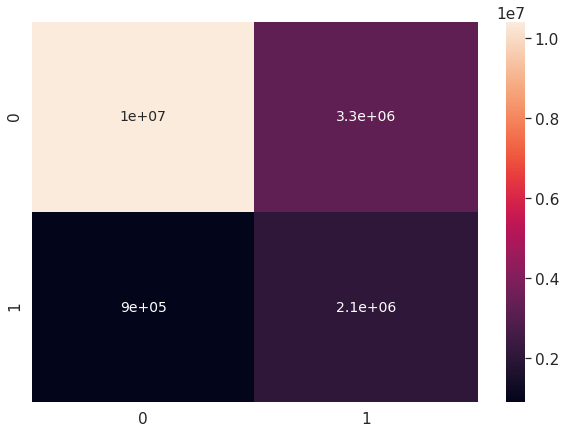

In [0]:
df_cm_train = pd.DataFrame(conf_mat_train, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_train, annot=True, annot_kws={"size": 14}) # font size


# |TN FN|
# |FP TP|
plt.show()

##### Validation Analysis

In [0]:
y_val_true = valScoreAndLabels_pd["label"]
y_val_pred = valScoreAndLabels_pd["raw"]
conf_mat_val = confusion_matrix(y_val_true, y_val_pred)

In [0]:
print("Accuracy Score: ", accuracy_score(y_val_true, y_val_pred))
print("F1 Score: ", f1_score(y_val_true, y_val_pred))
print(classification_report(y_val_true, y_val_pred))

Accuracy Score: 0.7237838407968141
F1 Score: 0.4043244599035813
 precision recall f1-score support

 0.0 0.88 0.77 0.82 5730843
 1.0 0.33 0.51 0.40 1285097

 accuracy 0.72 7015940
 macro avg 0.60 0.64 0.61 7015940
weighted avg 0.78 0.72 0.74 7015940

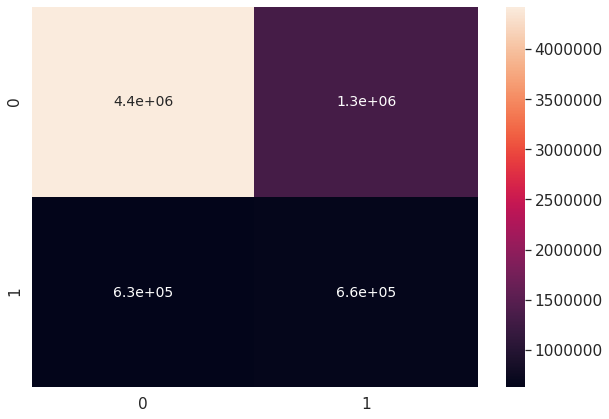

In [0]:
df_cm_val = pd.DataFrame(conf_mat_val, range(2), range(2))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_val, annot=True, annot_kws={"size": 14}) # font size


# |TN FN|
# |FP TP|
plt.show()